In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
SAVE_DIR = "/content/drive/MyDrive/rl_final_project/ppo/trivia"
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

!pip install torch transformers datasets sentence-transformers faiss-cpu peft bitsandbytes -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import faiss
from typing import List
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer

MODEL_ID = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
MAX_SEQ_LEN = 512
GENERATE_LEN = 64
LR = 1e-5
MAX_STEPS = 5
NUM_EPISODES = 10000
PRINT_EVERY = 100
SAVE_EVERY = 500

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4


In [4]:
import string
import re

class E5Retriever:
    def __init__(self, model_name="intfloat/e5-small-v2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name, device=self.device)
        self.index = None
        self.docs = []

    def build_index(self, docs: List[str]):
        print(f"Building index for {len(docs)} docs...")
        self.docs = docs
        embs = self.model.encode(["passage: " + d for d in docs],
                                 normalize_embeddings=True, show_progress_bar=False)
        self.index = faiss.IndexFlatIP(embs.shape[1])
        self.index.add(embs)

    def search(self, query: str, k=1):
        q_emb = self.model.encode(["query: " + query], normalize_embeddings=True)
        D, I = self.index.search(q_emb, k)
        return [self.docs[i] for i in I[0]]

class SearchR1Environment:
    def __init__(self, retriever):
        self.retriever = retriever

    def normalize_answer(self, s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def check_correctness(self, prediction, truth):
        pred_norm = self.normalize_answer(prediction)
        truth_norm = self.normalize_answer(truth)

        if pred_norm == truth_norm:
            return True

        if pred_norm in truth_norm and len(pred_norm) > 0:
            return True

        if truth_norm in pred_norm and len(truth_norm) > 0:
            return True

        return False

    def reset(self, question, answer):
        self.question = question
        self.ground_truth = answer
        self.history = []
        self.search_count = 0
        return self._format_prompt()

    def step(self, action):
        if action['type'] == 'search':
            if self.search_count >= 2: return self._format_prompt(), 0.0, False
            results = self.retriever.search(action['content'])
            context = f"\n<information>{results[0][:200]}</information>"
            self.history.append({'type': 'search', 'query': action['content'], 'result': context})
            self.search_count += 1
            return self._format_prompt(), 0.0, False

        elif action['type'] == 'answer':
            is_correct = self.check_correctness(action['content'], self.ground_truth)
            reward = 1.0 if is_correct else 0.0
            return self._format_prompt(), reward, True

        else:
            self.history.append({'type': 'think', 'content': action['content']})
            return self._format_prompt(), 0.0, False

    def _format_prompt(self):
        prompt = f"<|im_start|>user\n{self.question}\nUse <search>...</search> to search. <answer>...</answer> to finish.<|im_end|>\n<|im_start|>assistant\n"
        for h in self.history:
            if h['type'] == 'think': prompt += f"<think>{h['content']}</think>\n"
            elif h['type'] == 'search': prompt += f"<search>{h['query']}</search>\n{h['result']}\n"
        return prompt

print("Environment Ready (With Normalization)")

Environment Ready (With Normalization)


In [5]:
print("Loading Model...")

CHECKPOINT_PATH = f"{SAVE_DIR}/final"

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found checkpoint at {CHECKPOINT_PATH}, loading...")

    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
    tokenizer.pad_token = tokenizer.eos_token

    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    from peft import PeftModel
    model = PeftModel.from_pretrained(base_model, CHECKPOINT_PATH)

    print("✓ Loaded from checkpoint")
else:
    print("No checkpoint found, loading fresh model...")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    peft_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    )
    model = get_peft_model(model, peft_config)

    print("✓ Loaded fresh model")

VOCAB_SIZE = len(tokenizer)
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Model embedding size: {model.get_input_embeddings().weight.shape[0]}")
model.print_trainable_parameters()

Loading Model...
No checkpoint found, loading fresh model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


✓ Loaded fresh model
Vocab size: 49152
Model embedding size: 49152
trainable params: 18,087,936 || all params: 1,729,464,320 || trainable%: 1.0459


In [6]:
class SafePolicyNetwork(nn.Module):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device
        self.vocab_size = len(tokenizer)

    def generate(self, prompt):
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN,
            padding=False
        ).to(self.device)

        assert inputs['input_ids'].max() < self.vocab_size, f"Token {inputs['input_ids'].max()} >= vocab {self.vocab_size}"

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_new_tokens=GENERATE_LEN,
                do_sample=False,  
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )

        gen_seq = outputs[0][inputs['input_ids'].shape[1]:]

        if gen_seq.max() >= self.vocab_size:
            print(f"WARNING: Generated token {gen_seq.max()} >= vocab {self.vocab_size}")
            gen_seq = torch.clamp(gen_seq, 0, self.vocab_size - 1)

        text = self.tokenizer.decode(gen_seq, skip_special_tokens=False)
        return text

    def get_hidden_state(self, prompt):
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                output_hidden_states=True
            )
        return outputs.hidden_states[-1][:, -1, :]

class ValueHead(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.head = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden_states):
        return self.head(hidden_states.float()).squeeze(-1)  

policy = SafePolicyNetwork(model, tokenizer)
value_head = ValueHead(model.config.hidden_size).to(policy.device)

value_head_path = f"{CHECKPOINT_PATH}/value_head.pt"
if os.path.exists(value_head_path):
    value_head.load_state_dict(torch.load(value_head_path))
    print("✓ Loaded value head from checkpoint")


optimizer = torch.optim.AdamW([
    {'params': [p for p in model.parameters() if p.requires_grad], 'lr': LR},
    {'params': value_head.parameters(), 'lr': LR * 10}
])

print("Policy Ready")

print("\nTesting generation...")
test_out = policy.generate("Hello, how are you?")
print(f"Test output: {test_out[:100]}...")

Policy Ready

Testing generation...
Test output:  I'm doing great, thanks for asking! I've been thinking about our last project and I have an idea fo...


In [7]:
class SearchR1Trainer:
    def __init__(self, policy, value_head, optimizer, env):
        self.policy = policy
        self.value_head = value_head
        self.optimizer = optimizer
        self.env = env
        self.device = policy.device

    def parse_action(self, text):
        text_lower = text.lower()
        if "<answer>" in text_lower or "answer:" in text_lower:
            if "<answer>" in text:
                content = text.split("<answer>")[-1].split("</answer>")[0]
            else:
                content = text.split("answer:")[-1].split("\n")[0]
            return {'type': 'answer', 'content': content}
        if "<search>" in text_lower or "search:" in text_lower:
            if "<search>" in text:
                content = text.split("<search>")[-1].split("</search>")[0]
            else:
                content = text.split("search:")[-1].split("\n")[0]
            return {'type': 'search', 'content': content}
        return {'type': 'think', 'content': text[:100]}

    def train_step(self, question, answer):
        self.policy.model.train()
        self.optimizer.zero_grad()

        prompt = self.env.reset(question, answer)
        trajectory = []
        done = False

        for step_idx in range(MAX_STEPS):
            if done:
                break

            action_text = self.policy.generate(prompt)
            action = self.parse_action(action_text)

            hidden = self.policy.get_hidden_state(prompt)
            value = self.value_head(hidden)

            next_prompt, reward, done = self.env.step(action)
            trajectory.append({
                "prompt": prompt,
                "value": value.item(),
                "reward": reward
            })
            prompt = next_prompt

        if not trajectory:
            return 0.0, 0.0

        returns = []
        R = 0
        for step in reversed(trajectory):
            R = step['reward'] + 0.99 * R
            returns.insert(0, R)

        total_loss = 0.0
        for i, step in enumerate(trajectory):
            inputs = self.policy.tokenizer(
                step['prompt'],
                return_tensors="pt",
                truncation=True,
                max_length=MAX_SEQ_LEN
            ).to(self.device)

            outputs = self.policy.model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                output_hidden_states=True
            )
            hidden = outputs.hidden_states[-1][:, -1, :]
            value = self.value_head(hidden)

            target = torch.tensor([returns[i]], device=self.device, dtype=torch.float32)
            loss = F.mse_loss(value, target)
            loss.backward()
            total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), 1.0)
        self.optimizer.step()

        return total_loss, trajectory[-1]['reward']

print("Trainer Ready")

✓ Trainer Ready


In [8]:
from matplotlib import pyplot as plt

def plot_results(data, title="Results", xlabel="Episode", ylabel="Value", window=100, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = list(range(1, len(data) + 1))
    ax.plot(episodes, data, alpha=0.3, color='blue', label='Raw')

    if len(data) >= window:
        smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
        ax.plot(range(window, len(data) + 1), smoothed, color='blue', linewidth=2, label=f'Smoothed (w={window})')

    cumulative_avg = np.cumsum(data) / np.arange(1, len(data) + 1)
    ax.plot(episodes, cumulative_avg, color='red', linestyle='--', linewidth=2, label='Cumulative Avg')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    return cumulative_avg[-1] if len(data) > 0 else 0

In [9]:
def get_dataset(
    name,
    subset_size,
    ds_type
):

  if name == "gsm8k":
    if ds_type == 'train':
      train_ds = load_dataset("openai/gsm8k", "main", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a.split('####')[-1].strip() for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("openai/gsm8k", "main", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a.split('####')[-1].strip() for a in test_ds['answer']]
      return questions, answers

  if name == "trivia_qa":
    if ds_type == 'train':
      train_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a['value'] for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a['value'] for a in test_ds['answer']]
      return questions, answers


def get_dataset_split():
    print("Loading TriviaQA dataset...")

    ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train[:20000]")

    ds = ds.shuffle(seed=42)
    subset_size = 10000
    ds = ds.select(range(subset_size))

    questions = ds['question']
    answers = [a['value'] for a in ds['answer']]

    split_idx = int(0.8 * len(questions))

    train_questions = questions[:split_idx]
    train_answers = answers[:split_idx]

    test_questions = questions[split_idx:]
    test_answers = answers[split_idx:]

    print(f"Dataset loaded and split:")
    print(f"  - Total: {len(questions)}")
    print(f"  - Train: {len(train_questions)} (80%)")
    print(f"  - Test:  {len(test_questions)} (20%)")

    return (train_questions, train_answers), (test_questions, test_answers)

In [10]:
(questions, answers), (test_questions, test_answers) = get_dataset_split()

retriever = E5Retriever()
retriever.build_index([f"Q: {q}\nA: {a}" for q, a in zip(questions, answers)])

env = SearchR1Environment(retriever)
trainer = SearchR1Trainer(policy, value_head, optimizer, env)

Loading TriviaQA dataset...


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Dataset loaded and split:
  - Total: 10000
  - Train: 8000 (80%)
  - Test:  2000 (20%)
Building index for 8000 docs...


NOTE: The model is loaded from a checkpoint. The logs are only visible for last 100 episodes due to training restart from the last checkpoint. 


TRAINING
Episode 100/100 | Loss: 0.4269 | Reward: 0.4100

 Training Complete


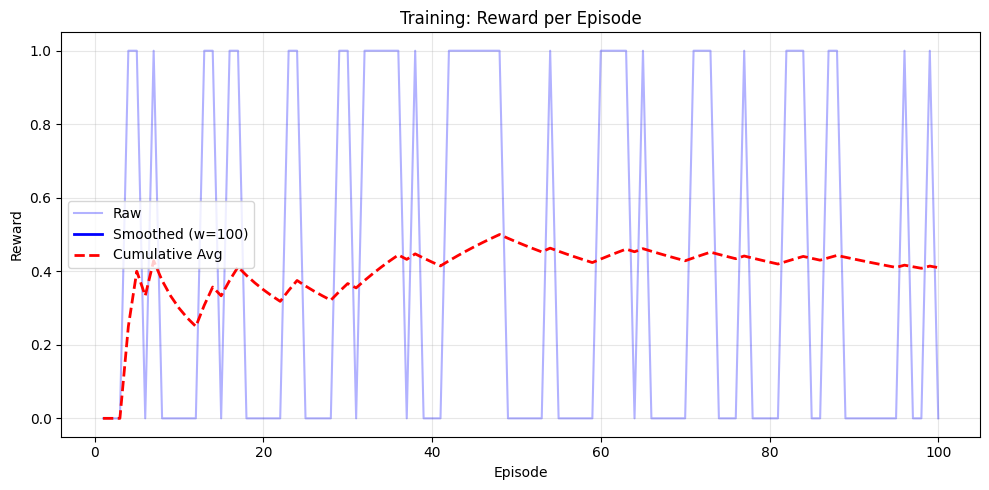

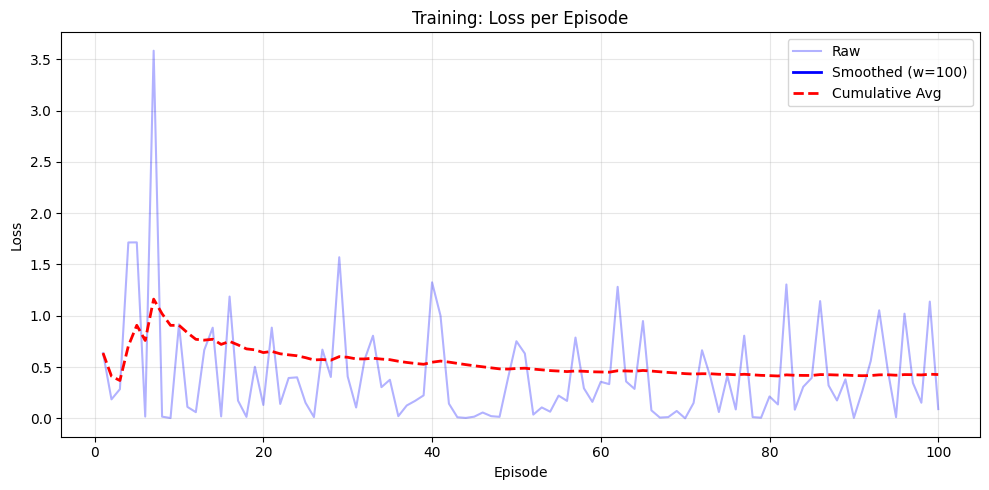

np.float64(0.4268752460728865)

In [11]:
print("\n" + "="*50)
print("TRAINING")
print("="*50)

train_losses = []
train_rewards = []
indices = list(range(len(questions)))
np.random.shuffle(indices)

for episode in range(NUM_EPISODES):
    if episode % len(questions) == 0:
        np.random.shuffle(indices)
    idx = indices[episode % len(questions)]

    loss, reward = trainer.train_step(questions[idx], answers[idx])
    train_losses.append(loss)
    train_rewards.append(reward)

    if (episode + 1) % PRINT_EVERY == 0:
        avg_loss = sum(train_losses[-PRINT_EVERY:]) / PRINT_EVERY
        avg_reward = sum(train_rewards[-PRINT_EVERY:]) / PRINT_EVERY
        print(f"Episode {episode+1}/{NUM_EPISODES} | Loss: {avg_loss:.4f} | Reward: {avg_reward:.4f}")

    if (episode + 1) % SAVE_EVERY == 0:
        ckpt_path = f"{SAVE_DIR}/episode_{episode+1}"
        model.save_pretrained(ckpt_path)
        tokenizer.save_pretrained(ckpt_path)
        torch.save(value_head.state_dict(), f"{ckpt_path}/value_head.pt")
        print(f"Saved: {ckpt_path}")

ckpt_path = f"{SAVE_DIR}/final"
model.save_pretrained(ckpt_path)
tokenizer.save_pretrained(ckpt_path)
torch.save(value_head.state_dict(), f"{ckpt_path}/value_head.pt")

print("\n Training Complete")
plot_results(train_rewards, "Training: Reward per Episode", "Episode", "Reward", 100, f"{SAVE_DIR}/train_rewards.png")
plot_results(train_losses, "Training: Loss per Episode", "Episode", "Loss", 100, f"{SAVE_DIR}/train_losses.png")


=== EVALUATION (100 episodes) ===
Episode 100/100 | Avg Reward: 0.4200

✓ Evaluation Complete
  Avg Reward: 0.4200
  Success Rate: 42.00%


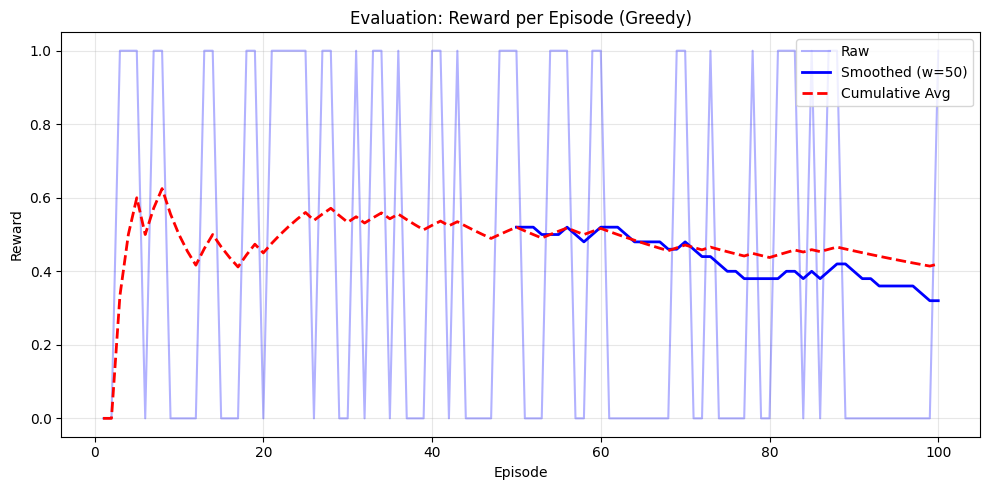

np.float64(0.42)

In [12]:
test_questions = test_questions[:100]
test_answers = test_answers[:100]


NUM_TEST_EPISODES = len(test_questions)
PRINT_EVERY = 100
MAX_STEPS = 5

test_rewards = []
model.eval()

print(f"\n=== EVALUATION ({NUM_TEST_EPISODES} episodes) ===")

for episode in range(NUM_TEST_EPISODES):
    state = env.reset(test_questions[episode], test_answers[episode])
    episode_reward = 0.0

    for _ in range(MAX_STEPS):
        with torch.no_grad():
            action_text = policy.generate(state)
        action = trainer.parse_action(action_text)
        state, reward, done = env.step(action)
        episode_reward += reward
        if done:
            break

    test_rewards.append(episode_reward)

    if (episode + 1) % PRINT_EVERY == 0:
        avg_reward = sum(test_rewards) / len(test_rewards)
        print(f"Episode {episode+1}/{NUM_TEST_EPISODES} | Avg Reward: {avg_reward:.4f}")

final_avg = sum(test_rewards) / len(test_rewards)
print(f"\n✓ Evaluation Complete")
print(f"  Avg Reward: {final_avg:.4f}")
print(f"  Success Rate: {final_avg * 100:.2f}%")

plot_results(test_rewards, "Evaluation: Reward per Episode (Greedy)", "Episode", "Reward", 50, f"{SAVE_DIR}/test_rewards.png")
